In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from utils import * ### need utils.py in the same folder as this notebook
from common import * ### need common.py in the same folder as this notebook

idx = pd.IndexSlice
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 300)
pd.set_option('mode.chained_assignment', 'raise')
pd.set_option('display.float_format', lambda x: '%.4f' % x) #supress scientific notation

/home/vec/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/vec/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# 1. Generating whole data set

In [2]:
rnd = np.random.RandomState(1729)
max_num = 10000000

### data split
dict_split = {'train': [(1, 100), (2, 100), (3, 100)], # ili:flu:covid=1
              'test': [(1, 30), (2, 30), (3, 30)]    # ili:flu:covid=100:10:3
             }


### generating data based on dict_split
df_activity = pd.concat([generate_normalized_hr_sample(i, split, ili) for split,v in dict_split.items() 
                         for ili,n in v 
                         for i in rnd.choice(np.arange(1,max_num), n)
                        ])

### summarize generated data
print(df_activity.shape)
print('N =', count_unique_index(df_activity))
assert count_unique_index(df_activity) == df_activity.shape[0]/43
describe_datetimeindex(df_activity)

(16770, 24)
N = 390


count                            16770
mean     2020-04-09 11:26:46.153846016
min                2020-01-04 00:00:00
25%                2020-03-03 00:00:00
50%                2020-04-09 00:00:00
75%                2020-05-18 00:00:00
max                2020-07-11 00:00:00
Name: dt, dtype: object

In [3]:
### summary test:train:val
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
prop_table(df_activity['labels', 'split'])

,"(labels, split)",count,percent
0,train,12900,76.9200
1,test,3870,23.0800
2,Total,16770,100.0000


## 1.1 Generating training set
* in training and val, we only work on health/ill days, i.e. days with training label {0,1}
* so total 21 days per id
* finally {X_train, y_train_label}

In [4]:
### generating training
label_col = ('labels', 'training_labels') ###  training_labels {-1,0,1}, for all train,test,val
split_col = ('labels', 'split')           ### train/test/val
type_col = ('labels', 'ILI_type')       

days_ago = ['0days_ago', '1days_ago', '2days_ago', '3days_ago', '4days_ago', '5days_ago']
feature_cols = ['heart_rate__not_moving__max', 
                'heart_rate__resting_heart_rate',
                'heart_rate__stddev',
                'heart_rate__perc_50th']

keep_train = (df_activity[label_col].isin([0,1])  #trim buffer days (which has label -1)
                & (df_activity[split_col] == 'train')
                & (df_activity[type_col].isin([1,2,3]))
              )

X_train, y_train, filter_train = get_dataset(df_activity, keep_train, days_ago, feature_cols, label_col)
y_train_type = get_ili_type(df_activity, keep_train) 

## y_train only contains {0:healthy, 1:ill}, not adequate for multiclass setting
## y_train_type contains {1:ili, 2:fli, 3:covid}
## y_train_label contains {0:healthy, 1:ili, 2:fli, 3:covid}
y_train_label = y_train*y_train_type

(6300, 20) (6300,)
Missing rows percent = 13.70%
  (labels, training_labels)  count  percent
0                         0   4200  66.6700
1                         1   2100  33.3300
2                     Total   6300 100.0000


## 1.2 Generating test set
* same as the repo, in test set we keep all days, i.e. days with training label {-1,0,1}
* so total 43 days per id
* finally {X_test, y_test_label}

In [5]:
label_col = ('labels', 'training_labels') ###  training_labels {-1,0,1}, for all train,test,val
split_col = ('labels', 'split')           ### train/test/val
type_col = ('labels', 'ILI_type')       

days_ago = ['0days_ago', '1days_ago', '2days_ago', '3days_ago', '4days_ago', '5days_ago']
feature_cols = ['heart_rate__not_moving__max', 
                'heart_rate__resting_heart_rate',
                'heart_rate__stddev',
                'heart_rate__perc_50th']

keep_test = (df_activity[label_col].isin([0,1])
             & (df_activity[split_col] == 'test')
             & (df_activity[type_col].isin([1,2,3]))
            )

X_test, y_test, filter_test = get_dataset(df_activity, keep_test, days_ago, feature_cols, label_col)
y_test_type = get_ili_type(df_activity, keep_test)
y_test_label = y_test_type*y_test

(1890, 20) (1890,)
Missing rows percent = 12.33%
  (labels, training_labels)  count  percent
0                         0   1260  66.6700
1                         1    630  33.3300
2                     Total   1890 100.0000


# 2. Imputation of NA values
* na value only in X, either train/test
* use impute NA values by 0

In [6]:
# 0 imputation
X_train_0 = impute_na(X_train, 0)
X_test_0 = impute_na(X_test, 0)

# add intercept for train and test
X_train_numpy = add_ones(np.array(X_train_0))
y_train_numpy = np.transpose(one_hot_encoding(y_train_label))
X_test_numpy = add_ones(np.array(X_test_0))
y_test_numpy = np.transpose(one_hot_encoding(y_test_label))

# tensorization
X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32)


n_train_sample = X_train_numpy.shape[0]
n_test_sample = X_test_numpy.shape[0]
n_class = y_train_numpy.shape[1]
n_feature = X_train_numpy.shape[1]
print('num of training sample is:', n_train_sample)
print('num of test sample is:', n_test_sample)
print('num of class is:', n_class)
print('num of feature is:', n_feature)

num of training sample is: 6300
num of test sample is: 1890
num of class is: 4
num of feature is: 21


# 3. Baseline

* Unbalanced logit with intercept

In [63]:
base_clf = LogisticRegression(multi_class='multinomial', fit_intercept=True).fit(X_train_0, y_train_label)
base_pred = base_clf.predict(X_train_0)

# clf report
print(classification_report(y_train_label, base_pred))

# confuction matrix
from sklearn.metrics import confusion_matrix
base_cm = confusion_matrix(y_train_label, base_pred)
print(base_cm)

# auc for train and test
auc_base_train = roc_auc_score(y_train_label, base_clf.predict_proba(X_train_0), multi_class='ovr')
auc_base_test = roc_auc_score(y_test_label, base_clf.predict_proba(X_test_0), multi_class='ovr')
print('auc for train and test:')
print(auc_base_train)
print(auc_base_test)

# Cross entropy loss
from sklearn import metrics
loss_base_train = metrics.log_loss(y_train_label, base_clf.predict_proba(X_train_0))
loss_base_test = metrics.log_loss(y_test_label, base_clf.predict_proba(X_test_0))
print('C-E loss for train and test:')
print(loss_base_train)
print(loss_base_test)

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      4200
           1       0.00      0.00      0.00       700
           2       0.00      0.00      0.00       700
           3       0.62      0.21      0.31       700

    accuracy                           0.69      6300
   macro avg       0.33      0.30      0.28      6300
weighted avg       0.53      0.69      0.58      6300

[[4189    0    0   11]
 [ 675    0    0   25]
 [ 648    0    0   52]
 [ 556    0    0  144]]
auc for train and test:
0.6140840206916099
0.590985371000252
C-E loss for train and test:
0.9486052188578719
0.9584447619265863


/home/vec/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/vec/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/vec/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vec/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

# 4. NoisyGD

In [8]:
rep = 10

# params
beta_L = 2*np.sqrt(2)*n_train_sample
f0_minus_fniter_bound = np.log(n_class)*n_train_sample 
GS = 2

sigma1 = 30
sigma2 = 300
delta = 1e-6
clip_threshold = 20
eps_list = np.arange(0,2.05,0.05)

In [9]:
# sigma1=30
tr_l_30, te_l_30, tr_auc_30, te_auc_30 = run_multiple_noisy_gd(X_train=X_train_tensor, y_train=y_train_tensor, 
                                                   X_test=X_test_tensor, y_test=y_test_tensor, 
                                                   eps_list=eps_list, rep=rep, delta=delta, sigma=sigma1, 
                                                   beta_L=beta_L, f0_minus_fniter_bound=f0_minus_fniter_bound,
                                                   GS=2, clip_threshold=clip_threshold)

# sigma2=300
tr_l_300, te_l_300, tr_auc_300, te_auc_300 = run_multiple_noisy_gd(X_train=X_train_tensor, y_train=y_train_tensor, 
                                                   X_test=X_test_tensor, y_test=y_test_tensor, 
                                                   eps_list=eps_list, rep=rep, delta=delta, sigma=sigma2, 
                                                   beta_L=beta_L, f0_minus_fniter_bound=f0_minus_fniter_bound,
                                                   GS=2, clip_threshold=clip_threshold)

In [10]:
# np.save('tr_l_30.npy', tr_l_30)
# np.save('te_l_30.npy', te_l_30)
# np.save('tr_auc_30.npy', tr_auc_30)
# np.save('te_auc_30.npy', te_auc_30)
# np.save('tr_l_300.npy', tr_l_300)
# np.save('te_l_300.npy', te_l_300)
# np.save('tr_auc_300.npy', tr_auc_300)
# np.save('te_auc_300.npy', te_auc_300)

In [11]:
length = len(eps_list)
# reshape
tr_l_30 = np.array(tr_l_30).reshape((length,rep))
te_l_30 = np.array(te_l_30).reshape((length,rep))
tr_auc_30 = np.array(tr_auc_30).reshape((length,rep))
te_auc_30 = np.array(te_auc_30).reshape((length,rep))
# calculate mean
m_tr_l_30 = np.mean(tr_l_30, axis=1)/n_train_sample
m_te_l_30 = np.mean(te_l_30, axis=1)/n_test_sample
m_tr_auc_30 = np.mean(tr_auc_30, axis=1)
m_te_auc_30 = np.mean(te_auc_30, axis=1)

In [15]:
length = len(eps_list)
# reshape
tr_l_300 = np.array(tr_l_300).reshape((length,rep))
te_l_300 = np.array(te_l_300).reshape((length,rep))
tr_auc_300 = np.array(tr_auc_300).reshape((length,rep))
te_auc_300 = np.array(te_auc_300).reshape((length,rep))
# calculate mean
m_tr_l_300 = np.mean(tr_l_300, axis=1)/n_train_sample
m_te_l_300 = np.mean(te_l_300, axis=1)/n_test_sample
m_tr_auc_300 = np.mean(tr_auc_300, axis=1)
m_te_auc_300 = np.mean(te_auc_300, axis=1)

In [12]:
base_loss_train_array = np.repeat(loss_base_train, len(eps_list))
base_loss_test_array = np.repeat(loss_base_test, len(eps_list))
base_auc_train_array = np.repeat(auc_base_train, len(eps_list))
base_auc_test_array = np.repeat(auc_base_test, len(eps_list))

## comparison 30 and 300

* loss

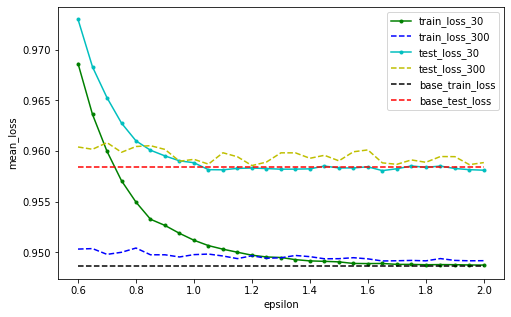

In [47]:
inter = 12
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter:], m_tr_l_30[inter:], 'g.-')
plt.plot(np.array(eps_list)[inter:], m_tr_l_300[inter:], 'b--')
plt.plot(np.array(eps_list)[inter:], m_te_l_30[inter:], 'c.-')
plt.plot(np.array(eps_list)[inter:], m_te_l_300[inter:], 'y--')
plt.plot(np.array(eps_list)[inter:], base_loss_train_array[inter:], 'k--')
plt.plot(np.array(eps_list)[inter:], base_loss_test_array[inter:], 'r--')
plt.legend(['train_loss_30','train_loss_300', 'test_loss_30', 'test_loss_300', 'base_train_loss', 'base_test_loss'])
plt.xlabel('epsilon')
plt.ylabel('mean_loss')
plt.show()

* auc

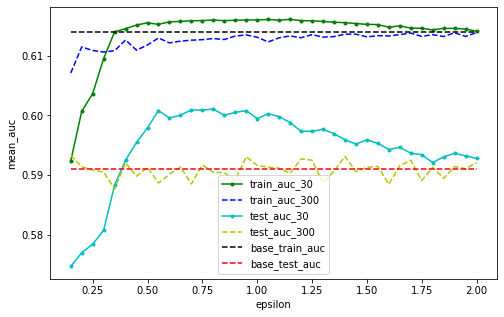

In [48]:
inter2 = 3
#%matplotlib inline 
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter2:], m_tr_auc_30[inter2:], 'g.-')
plt.plot(np.array(eps_list)[inter2:], m_tr_auc_300[inter2:], 'b--')
plt.plot(np.array(eps_list)[inter2:], m_te_auc_30[inter2:], 'c.-')
plt.plot(np.array(eps_list)[inter2:], m_te_auc_300[inter2:], 'y--')
plt.plot(np.array(eps_list)[inter2:], base_auc_train_array[inter2:], 'k--')
plt.plot(np.array(eps_list)[inter2:], base_auc_test_array[inter2:], 'r--')
plt.legend(['train_auc_30','train_auc_300', 'test_auc_30', 'test_auc_300', 'base_train_auc', 'base_test_auc'])
plt.xlabel('epsilon')
plt.ylabel('mean_auc')
plt.show()

## only 30

* loss

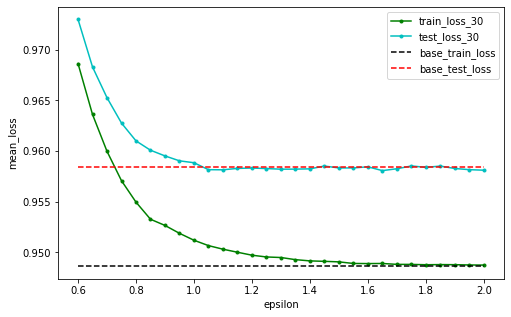

In [61]:
inter = 12
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter:], m_tr_l_30[inter:], 'g.-')
plt.plot(np.array(eps_list)[inter:], m_te_l_30[inter:], 'c.-')
plt.plot(np.array(eps_list)[inter:], base_loss_train_array[inter:], 'k--')
plt.plot(np.array(eps_list)[inter:], base_loss_test_array[inter:], 'r--')
plt.legend(['train_loss_30','test_loss_30', 'base_train_loss', 'base_test_loss'])
plt.xlabel('epsilon')
plt.ylabel('mean_loss')
plt.show()

* auc

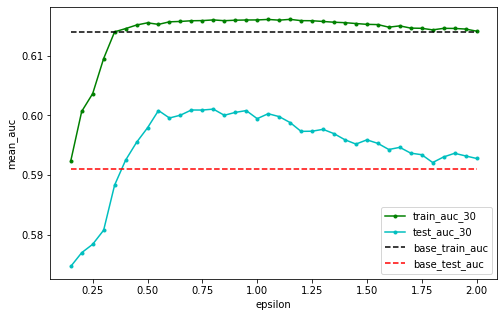

In [64]:
inter2 = 3
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter2:], m_tr_auc_30[inter2:], 'g.-')
plt.plot(np.array(eps_list)[inter2:], m_te_auc_30[inter2:], 'c.-')
plt.plot(np.array(eps_list)[inter2:], base_auc_train_array[inter2:], 'k--')
plt.plot(np.array(eps_list)[inter2:], base_auc_test_array[inter2:], 'r--')
plt.legend(['train_auc_30', 'test_auc_30', 'base_train_auc', 'base_test_auc'])
plt.xlabel('epsilon')
plt.ylabel('mean_auc')
plt.show()

# only 300

* loss

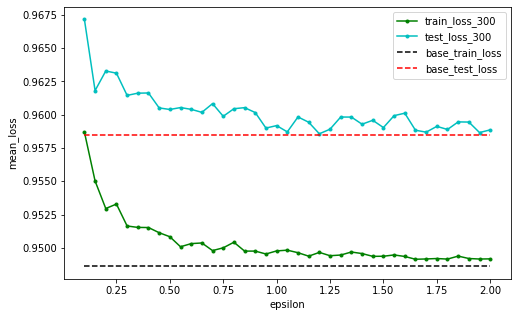

In [51]:
inter = 2
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter:], m_tr_l_300[inter:], 'g.-')
plt.plot(np.array(eps_list)[inter:], m_te_l_300[inter:], 'c.-')
plt.plot(np.array(eps_list)[inter:], base_loss_train_array[inter:], 'k--')
plt.plot(np.array(eps_list)[inter:], base_loss_test_array[inter:], 'r--')
plt.legend(['train_loss_300','test_loss_300', 'base_train_loss', 'base_test_loss'])
plt.xlabel('epsilon')
plt.ylabel('mean_loss')
plt.show()

* auc

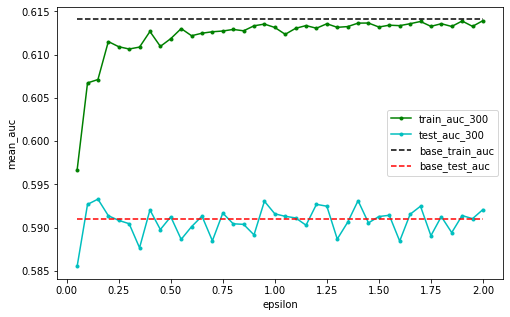

In [67]:
inter = 1
plt.figure(figsize=(8, 5))
plt.plot(np.array(eps_list)[inter:], m_tr_auc_300[inter:], 'g.-')
plt.plot(np.array(eps_list)[inter:], m_te_auc_300[inter:], 'c.-')
plt.plot(np.array(eps_list)[inter:], base_auc_train_array[inter:], 'k--')
plt.plot(np.array(eps_list)[inter:], base_auc_test_array[inter:], 'r--')
plt.legend(['train_auc_300','test_auc_300', 'base_train_auc', 'base_test_auc'])
plt.xlabel('epsilon')
plt.ylabel('mean_auc')
plt.show()